In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import davies_bouldin_score

In [2]:
# Now here i loaded the datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

### Task 1: Exploratory Data Analysis (EDA)

In [3]:
# Merge datasets for comprehensive analysis
data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price_x          1000 non-null   float64
 7   CustomerName     1000 non-null   object 
 8   Region           1000 non-null   object 
 9   SignupDate       1000 non-null   object 
 10  ProductName      1000 non-null   object 
 11  Category         1000 non-null   object 
 12  Price_y          1000 non-null   float64
dtypes: float64(3), int64(1), object(9)
memory usage: 101.7+ KB
None


In [6]:
print(data.describe())

          Quantity   TotalValue     Price_x     Price_y
count  1000.000000  1000.000000  1000.00000  1000.00000
mean      2.537000   689.995560   272.55407   272.55407
std       1.117981   493.144478   140.73639   140.73639
min       1.000000    16.080000    16.08000    16.08000
25%       2.000000   295.295000   147.95000   147.95000
50%       3.000000   588.880000   299.93000   299.93000
75%       4.000000  1011.660000   404.40000   404.40000
max       4.000000  1991.040000   497.76000   497.76000


In [7]:
# 1. Top 5 products by sales
product_sales = data.groupby('ProductName')['TotalValue'].sum().sort_values(ascending=False).head(5)
print("Top 5 products by sales:\n", product_sales)

Top 5 products by sales:
 ProductName
ActiveWear Smartwatch    39096.97
SoundWave Headphones     25211.64
SoundWave Novel          24507.90
ActiveWear Jacket        22712.56
ActiveWear Rug           22314.43
Name: TotalValue, dtype: float64


In [8]:
# 2. Most active customers (by number of transactions)
active_customers = data['CustomerID'].value_counts().head(5)
print("Most active customers:\n", active_customers)

Most active customers:
 CustomerID
C0109    11
C0156    11
C0141    10
C0175    10
C0065    10
Name: count, dtype: int64


In [9]:
# 3. Total sales by region
region_sales = data.groupby('Region')['TotalValue'].sum()
print("Total sales by region:\n", region_sales)

Total sales by region:
 Region
Asia             152074.97
Europe           166254.63
North America    152313.40
South America    219352.56
Name: TotalValue, dtype: float64


In [10]:
# 4. Monthly sales trend
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data['Month'] = data['TransactionDate'].dt.to_period('M')
monthly_sales = data.groupby('Month')['TotalValue'].sum()
print("Monthly sales trend:\n", monthly_sales)

Monthly sales trend:
 Month
2023-12     3769.52
2024-01    66376.39
2024-02    51459.27
2024-03    47828.73
2024-04    57519.06
2024-05    64527.74
2024-06    48771.18
2024-07    71366.39
2024-08    63436.74
2024-09    70603.75
2024-10    47063.22
2024-11    38224.37
2024-12    59049.20
Freq: M, Name: TotalValue, dtype: float64


In [11]:
# 5. Customer signup trends
data['SignupDate'] = pd.to_datetime(data['SignupDate'])
data['SignupYear'] = data['SignupDate'].dt.year
signup_trends = data['SignupYear'].value_counts()
print("Customer signup trends:\n", signup_trends)

Customer signup trends:
 SignupYear
2024    387
2022    332
2023    281
Name: count, dtype: int64


### Task 2: Lookalike Model

In [13]:
print(data.columns)

Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price_x', 'CustomerName', 'Region',
       'SignupDate', 'ProductName', 'Category', 'Price_y', 'Month',
       'SignupYear'],
      dtype='object')


In [14]:
# Aggregate customer data
customer_profiles = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price_x': 'mean',
    'Region': lambda x: x.mode()[0]  # Most frequent region
}).reset_index()

In [15]:
# Encode region as numeric
dummy_regions = pd.get_dummies(customer_profiles['Region'], prefix='Region')
customer_profiles = pd.concat([customer_profiles, dummy_regions], axis=1).drop('Region', axis=1)

In [16]:
# Compute similarity
similarity_matrix = cosine_similarity(customer_profiles.iloc[:, 1:])

In [17]:
# Find top 3 similar customers for first 20 customers
lookalikes = {}
for i in range(20):
    similar_indices = np.argsort(-similarity_matrix[i])[1:4]  # Exclude self (index 0)
    lookalikes[customer_profiles['CustomerID'].iloc[i]] = [
        (customer_profiles['CustomerID'].iloc[j], similarity_matrix[i][j]) for j in similar_indices
    ]

In [18]:
# Save lookalike results
lookalike_df = pd.DataFrame({
    'CustomerID': [key for key in lookalikes],
    'Lookalikes': [value for value in lookalikes.values()]
})
lookalike_df.to_csv('Lookalike.csv', index=False)

In [26]:
print(lookalike_df)

   CustomerID                                         Lookalikes
0       C0001  [(C0024, 0.9999995602895471), (C0189, 0.999999...
1       C0002  [(C0129, 0.9999986241739094), (C0019, 0.999997...
2       C0003  [(C0179, 0.9999986381164016), (C0190, 0.999997...
3       C0004  [(C0045, 0.9999997425878637), (C0143, 0.999999...
4       C0005  [(C0132, 0.9999940595499688), (C0089, 0.999992...
5       C0006  [(C0152, 0.9999999408020365), (C0011, 0.999999...
6       C0007  [(C0085, 0.9999994629015712), (C0061, 0.999999...
7       C0008  [(C0162, 0.9999994853786862), (C0018, 0.999999...
8       C0009  [(C0080, 0.9999989356162494), (C0020, 0.999998...
9       C0010  [(C0047, 0.9999966614866559), (C0030, 0.999996...
10      C0011  [(C0006, 0.999999787825755), (C0152, 0.9999997...
11      C0012  [(C0093, 0.9999999361642606), (C0046, 0.999999...
12      C0013  [(C0108, 0.999999954266087), (C0105, 0.9999998...
13      C0014  [(C0150, 0.9999916698493704), (C0130, 0.999991...
14      C0015  [(C0083, 0

### Task 3: Customer Segmentation / Clustering

In [19]:
# Standardize numeric features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_profiles.iloc[:, 1:])

In [21]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
customer_profiles['Cluster'] = clusters

c:\Users\Subhash Gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [22]:
# Calculate DB Index
db_index = davies_bouldin_score(scaled_data, clusters)
print("Davies-Bouldin Index:", db_index)

Davies-Bouldin Index: 0.9319194864587907


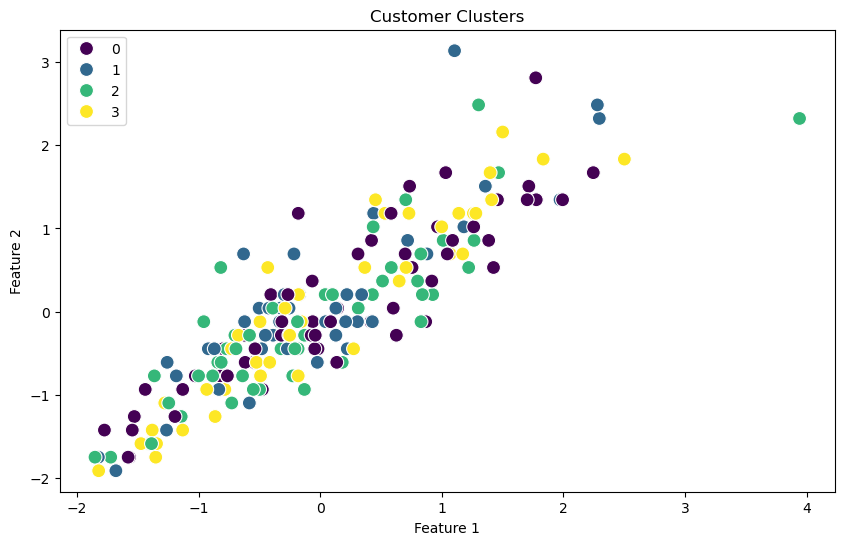

In [23]:
# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=scaled_data[:, 0], y=scaled_data[:, 1], hue=clusters, palette='viridis', s=100
)
plt.title('Customer Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [24]:
# Save clustering results
customer_profiles.to_csv('Customer_Segmentation.csv', index=False)